In [10]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns
import scipy
import pycountry_convert as pc
%matplotlib inline

In [11]:
class Value:
    def __init__(self, year: int, value: float):
        self.year = year
        self.value = value
    def set_loc(self, loc: str):
        self.loc = loc
    def set_country(self, country: str):
        self.country = country
    def __str__(self):
        return f"{self.year}: {self.value}"
    def __eq__(self, other):
        if not isinstance(other, Value):
            return NotImplemented
        return (self.year == other.year and self.value == other.value)

In [12]:
def convert_index(m: map) -> map:
    values = {}
    for x in list(m.keys()):
        values[x] = []
        for val in m[x]:
            values[x].append(val.value)
        values[x].sort()
    return values

def combine(m: map) -> list:
    p = []
    for x in list(m.keys()):
        if (x == "pooled"): continue
        p.extend(m[x])
    m["pooled"] = p
    return m

def map_year(m: map) -> list:
    year_map = {}
    combine(m)
    for i in range(len(m["pooled"])):
        y = m["pooled"][i].year
        if (not y in year_map.keys()):
            year_map[y] = [m["pooled"][i]]
        else:
            year_map[y].append(m["pooled"][i])

    return year_map

In [13]:
def data_map(f: pd.core.frame.DataFrame, c_index: int, y_index: int, v_index: int) -> map:
    m = {}
    for i in range(0, len(f)):
        row = f.loc[i]
        c, y, v = row[c_index], row[y_index], row[v_index]
        if (math.isnan(v)): continue

        idx = Value(y, v)
        if (not c in m.keys()):
            m[c] = [idx]
        else:
            m[c].append(idx)
    return m

def csv_map(fn: str, c_index: int, y_index: int, v_index: int) -> map:
    ff = pd.read_csv(fn)
    m = data_map(ff, c_index, y_index, v_index)

    return m

def sort_map(m: map) -> map:
    k = list(m.keys())
    k.sort()
    sorted_map = {i: m[i] for i in k}
    return sorted_map

def crop_map(m: map, lb: int, ub: int) -> map:
    c = {}
    for x in list(m.keys()):
        if (x >= lb and x <= ub): c[x] = m[x]
    return c

def idx_to_float(v: list) -> list:
    f = []
    for x in v:
        f.append(x.value)
    return f

def filter_out(v: list) -> list:
    Q1, Q3 = np.quantile(v, 0.25), np.quantile(v, 0.75)
    IQR = (Q3 - Q1)
    lb, ub = Q1 - (1.5*IQR), Q3 + (1.5*IQR)
    out = []
    for x in v:
        if (x >= lb and x <= ub): out.append(x)
    return out

def get_out(m: map) -> map:
    o = {}
    for x in list(m.keys()):
        o[x] = list(set(m[x]) - set(filter_out(m[x])))
    return o

def remove_out(m: map) -> map:
    r = {}
    for x in list(m.keys()):
        r[x] = filter_out(m[x])
    return r

def filter_idx(m: map) -> map:
    f = {}
    tmp = remove_out(convert_index(m))
    for k in list(tmp.keys()):
        for x in m[k]: 
            if (x.value in tmp[k]):
                if (not k in f): f[k] = [x]
                else: f[k].append(x)
    return f

def set_c(m: map) -> map:
    c = {}
    for k in list(m.keys()):
        if (k == "pooled"): continue
        for x in m[k]: 
            x.set_country(k)
            if (not k in c): c[k] = [x]
            else: c[k].append(x)
    return c

def reconstruct(m: map) -> map:
    r = {}
    for k in list(m.keys()):
        for x in m[k]:
            c = x.country
            if (not c in r): r[c] = [x]
            else: r[c].append(x)
    return r

def transform(v: list, f):
    tf = []
    for x in v:
        tf.append(f(x))
    return tf

def transform_map(m: map, f): 
    tf = {}
    if (isinstance(list(m.values())[0][0], Value)):
        mm = convert_index(m)
    else:
        mm = m
    for x in list(m.keys()):
        tf[x] = transform(mm[x], f)
        
    return tf

In [14]:
def merged_box(m: map, title = "", xlabel = "", ylabel = "", fx = 30, fy = 10):
    data, labels = [], []
    for i in range(len(list(m.keys()))):
        k = list(m.keys())[i]
        if (k == "pooled"): continue
        data.append(m[k])
        labels.append(k)

    plt.figure(figsize=(fx, fy))
    plt.boxplot(data, labels=labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

def hist(v: list, title = "", xlabel = "", ylabel = "", fx = 10, fy = 10, density = False, bins = 15):
    plt.figure(figsize=(fx, fy))
    plt.hist(v, bins=bins, density=density)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

def density(v: list, title = "", xlabel = "", ylabel = "", bw = 0.5):
    sns.set_style('whitegrid')
    sns.kdeplot(v, bw_method=bw)

def violin(m: map, title = "", xlabel = "", ylabel = "", fx = 30, fy = 10):
    data, labels = [], []
    for i in range(len(list(m.keys()))):
        k = list(m.keys())[i]
        if (k == "pooled"): continue
        data.append(m[k])
        labels.append(k)
    plt.figure(figsize=(fx, fy))
    plt.violinplot(data, positions=labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

def plot(x: list, y: list, title = "", xlabel = "", ylabel = "", fx = 30, fy = 10):
    plt.figure(figsize=(fx, fy))
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
def scatter(x: list, y: list, title = "", xlabel = "", ylabel = "", fx = 30, fy = 10, m = None, b = None):
    plt.figure(figsize=(fx, fy))
    ax = plt.figure().add_subplot(111)
    if (m is not None and b is not None):
        out = linear(np.array(x), m, b)
        ax.plot(x, out, color='red', label=f"{m}x + {b}")
    
    ax.scatter(x, y, marker = 'o', s = 1)
    ax.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

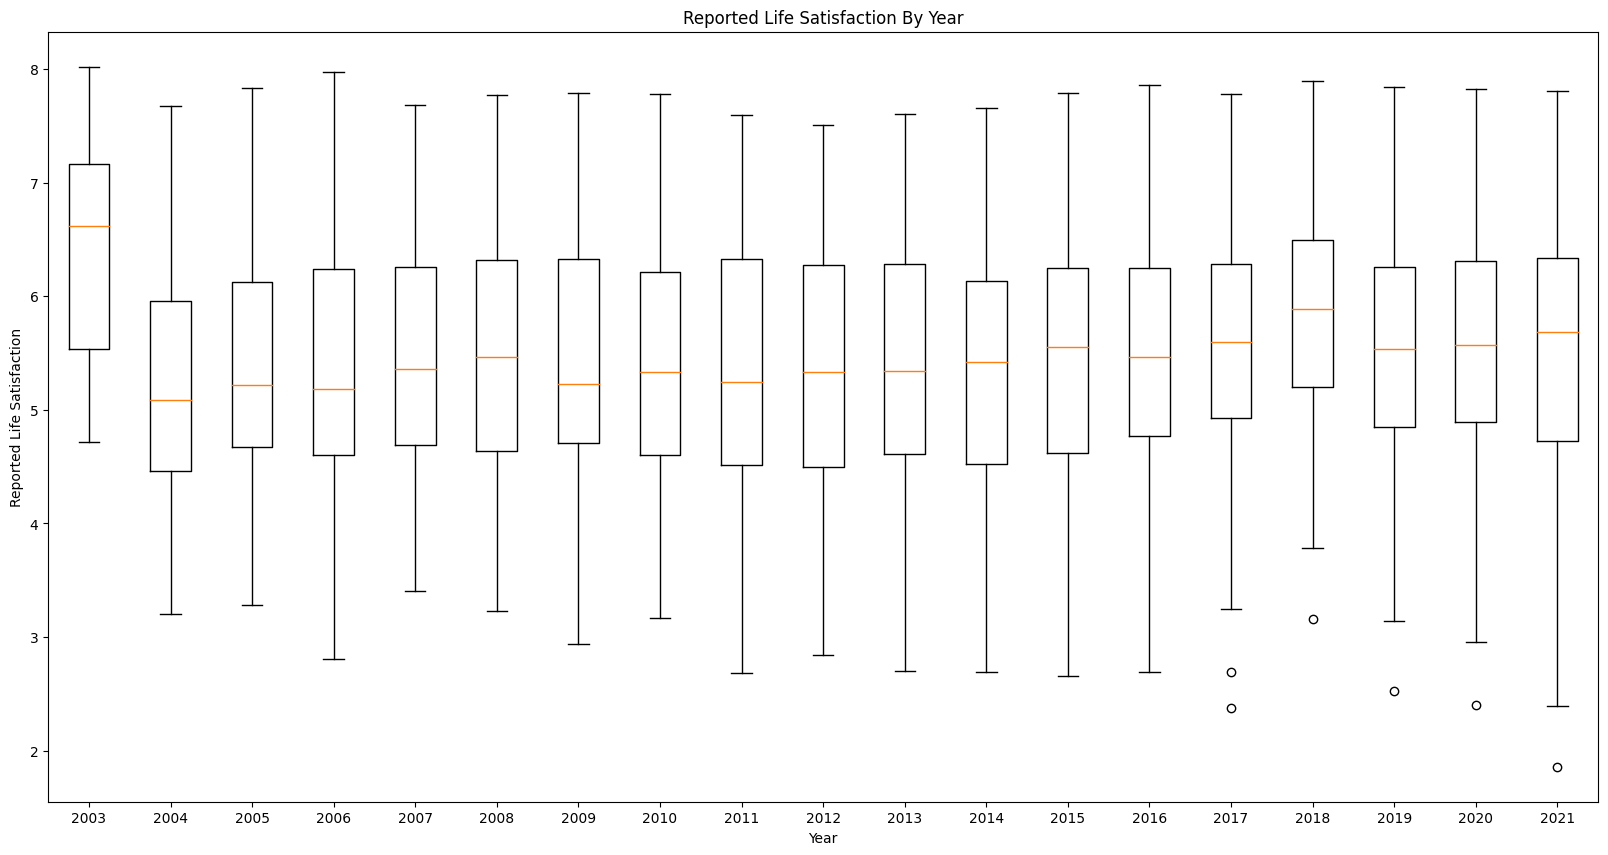

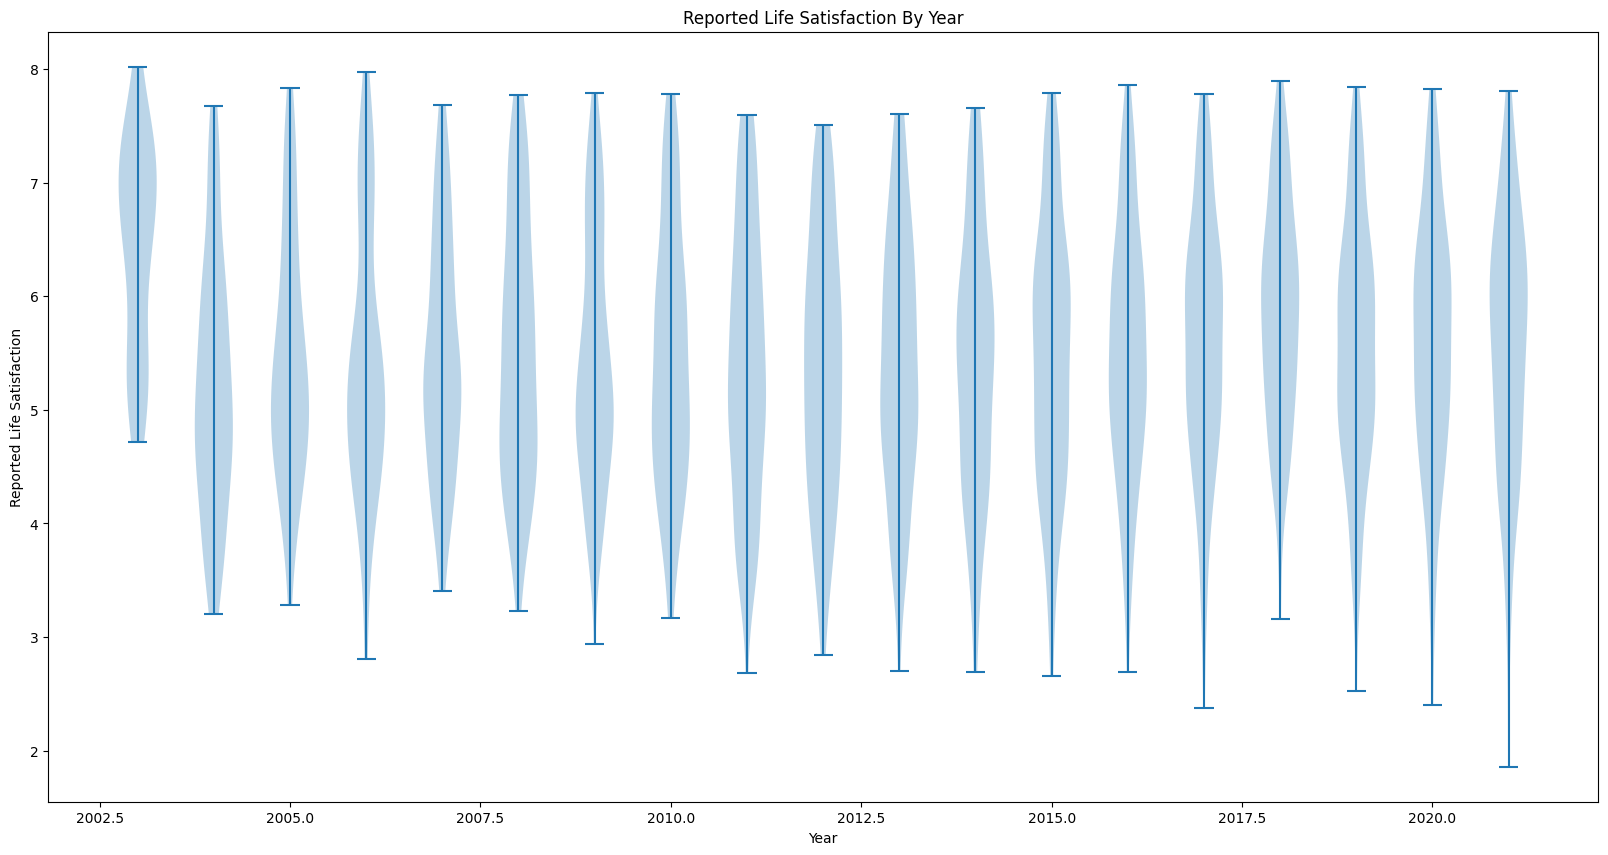

In [15]:
happiness = set_c(combine(csv_map("../stats/data/csv/cantril-ladder.csv", 0, 2, 3)))
phones = set_c(combine(csv_map("../stats/data/csv/cell-phones.csv", 0, 1, 2)))
internet = combine(csv_map("../stats/data/csv/internet-users.csv", 0, 1, 2))

ph = sort_map(convert_index(map_year(happiness)))

merged_box(ph, "Reported Life Satisfaction By Year", "Year", "Reported Life Satisfaction", fx=20, fy=10)
violin(ph, "Reported Life Satisfaction By Year", "Year", "Reported Life Satisfaction", fx=20, fy=10)

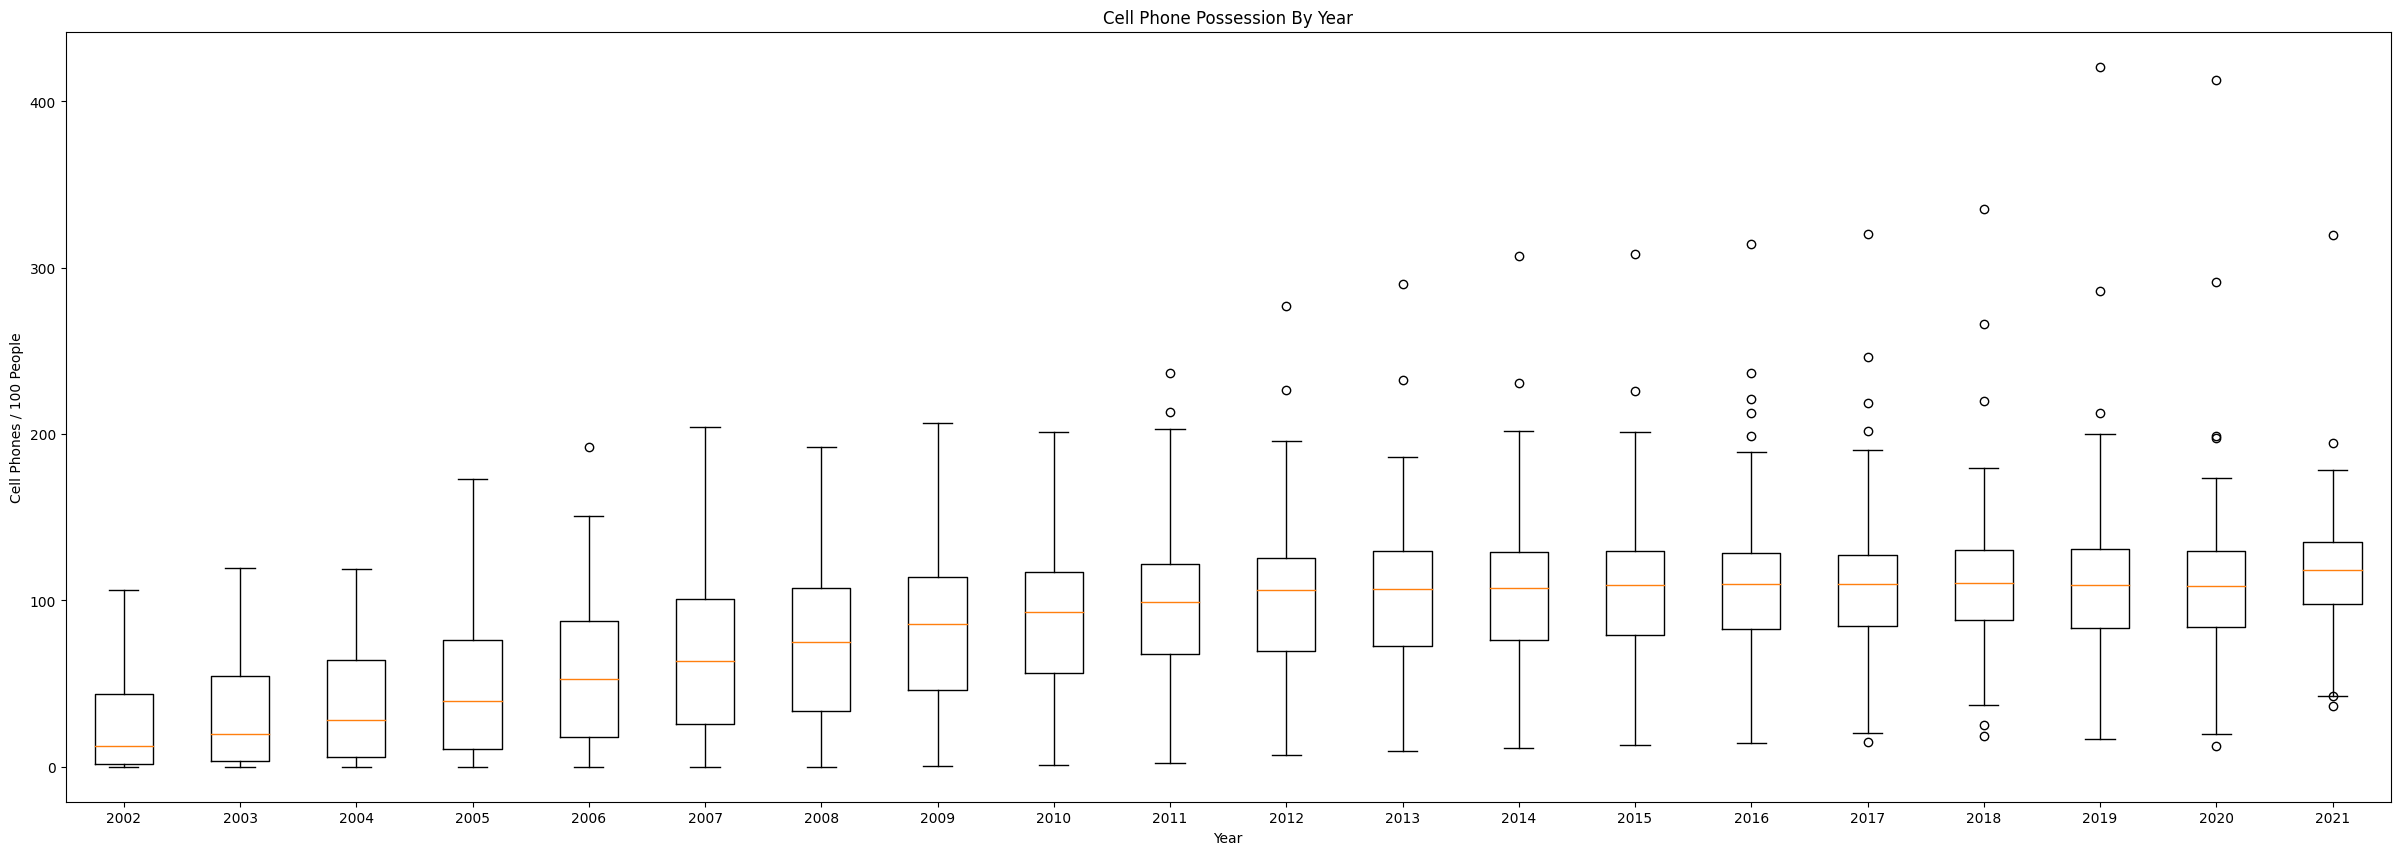

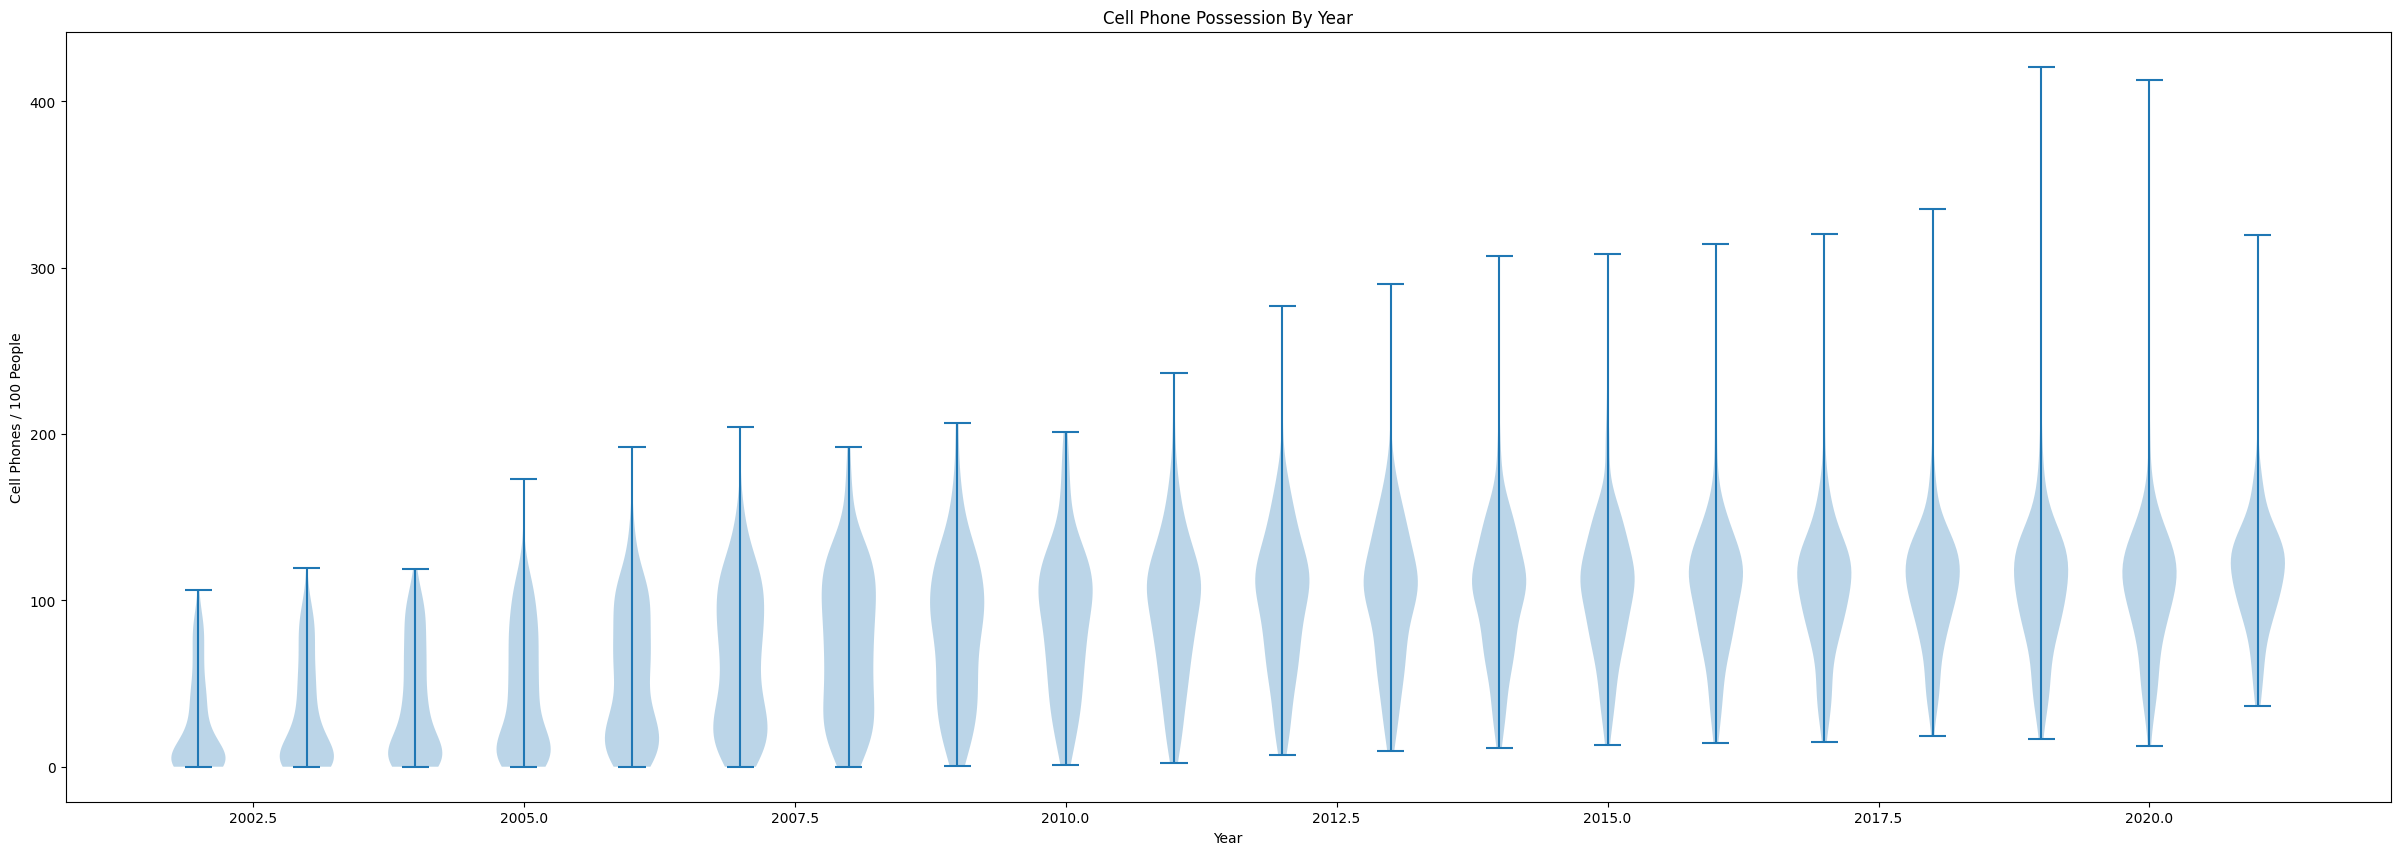

In [16]:
py = crop_map(sort_map(convert_index(map_year(phones))), 2002, 2023)

merged_box(py, "Cell Phone Possession By Year", "Year", "Cell Phones / 100 People")
violin(py, "Cell Phone Possession By Year", "Year", "Cell Phones / 100 People")

In [17]:
def eq(v1: Value, v2: Value) -> bool:
    return (v1.value == v2.value and v1.year == v2.year)

od, freq = {}, {}
out = get_out(py)
for k in list(out.keys()):
    for x in out[k]:
        v = Value(k, x)
        for n in list(phones.keys()):
            if (n == "pooled"): continue
            for i in phones[n]:
                if eq(v, i):
                    if (not n in od): od[n] = [v]
                    else: od[n].append(v)
                    if (not n in freq): freq[n] = 1
                    else: freq[n] += 1

print(convert_index(od))
print(freq)
for x in list(od.keys()):
    s = f"{x}: "
    for i in od[x]: s += f"{str(i.year)} "
    print(s)

{'cym': [192.1228], 'mac': [236.98544, 276.8619, 290.24612, 307.27481, 308.18869, 314.34653, 320.54042, 335.05747, 412.99279, 420.8531], 'hkg': [213.13099, 226.01089, 226.53304, 230.67237, 232.60981, 236.48657, 246.52841, 265.97125, 286.22448, 291.49897, 319.42626], 'atg': [198.56687, 198.75447, 201.93374], 'bhr': [212.45285], 'are': [194.73362, 197.84387, 212.80444, 218.6323, 219.70067, 221.30877], 'prk': [14.93162], 'ssd': [12.6718, 18.43381], 'caf': [25.10925], 'kir': [42.31032], 'sdn': [36.55233]}
{'cym': 1, 'mac': 10, 'hkg': 11, 'atg': 3, 'bhr': 1, 'are': 6, 'prk': 1, 'ssd': 2, 'caf': 1, 'kir': 1, 'sdn': 1}
cym: 2006 
mac: 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 
hkg: 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 
atg: 2016 2017 2020 
bhr: 2016 
are: 2016 2017 2018 2019 2020 2021 
prk: 2017 
ssd: 2018 2020 
caf: 2018 
kir: 2021 
sdn: 2021 


In [21]:
m = {}
iqr = {}

for x in list(py.keys()):
    dat = data(py[x])
    m[x] = dat["median"]
    iqr[x] = dat["Q3"] - dat["Q1"]


#plot(list(m.keys()), list(m.values()), title = "Median of Cell Phones Possessed / 100 People Over Time", xlabel = "Year", ylabel = "Median of Cell Phones Possessed")
#plot(list(iqr.keys()), list(iqr.values()), title = "IQR of Cell Phones Possessed / 100 People Over Time", xlabel = "Year", ylabel = "IQR of Cell Phones Possessed")
med = list(crop_map(m, 2012, 2023).values())
d = data(med)
d["Q3"] - d["Q1"]

1.98661125000001

In [22]:
#hist(py[2001], title = "Cell Phones Possessed / 100 People (1999)", xlabel="Phones Possessed", ylabel="Frequency", density=False)

In [23]:
def sd(v: list) -> float:
    assert(len(v) != 0)
    s, m = 0, sum(v)/len(v)

    for x in v:
        s += pow(x - m, 2)
    s /= len(v) - 1
    return math.sqrt(s)

def data(v: list) -> map:
    assert(len(v) != 0)
    dat = {}
    dat["count"] = len(v)
    dat["sum"] = sum(v)
    dat["median"] = np.quantile(v, 0.5)
    dat["Q1"] = np.quantile(v, 0.25)
    dat["Q3"] = np.quantile(v, 0.75)
    dat["mean"] = sum(v)/len(v)
    dat["range"] = max(v) - min(v)
    dat["sd"] = sd(v)
    dat["var"] = pow(sd(v), 2)
    dat["min"] = min(v)
    dat["max"] = max(v)

    return dat

def map_data(m: map) -> map:
    dat = {}
    for x in list(m.keys()):
        dat[x] = data(m[x])
    return dat

def linear(x: float, m: float, b: float) -> float:
    return m*x + b

In [24]:
def plot_mean(m: map, title = "", xlabel = "", ylabel = "", fx = 10, fy = 10):
    dat = map_data(m)
    x, y = [], []
    for k in list(dat.keys()):
        x.append(k)
        y.append(dat[k]["mean"])

    plt.figure(figsize=(fx, fy))
    plt.scatter(x, y, linestyle="dotted")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    diff = x[1] - x[0]

    for k in range(0, len(x)):
        key = x[k]
        px = np.linspace(x[k] - diff/2, x[k] + diff/2, 20, dtype=float)
        y1, y2 = (dat[key]["mean"] - dat[key]["sd"] + 0*px), (dat[key]["mean"] + dat[key]["sd"] + 0*px)
        plt.fill_between(px, y1, y2, color = 'green', alpha = 0.25)


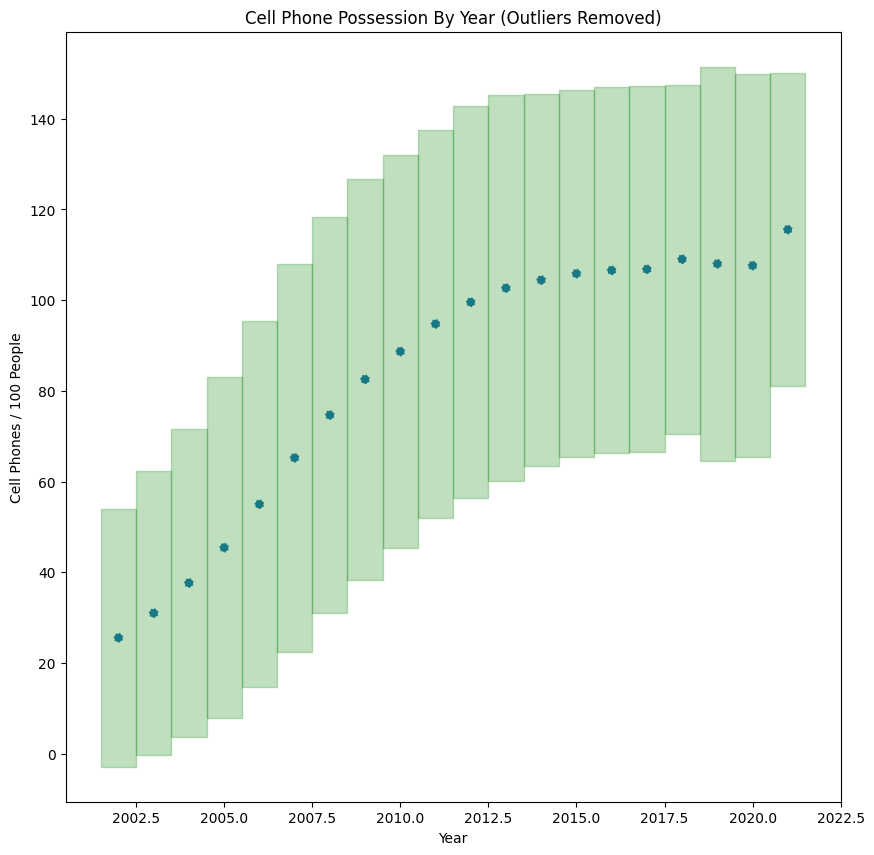

In [25]:
plot_mean(py, "Cell Phone Possession By Year (Outliers Removed)", "Year", "Cell Phones / 100 People")

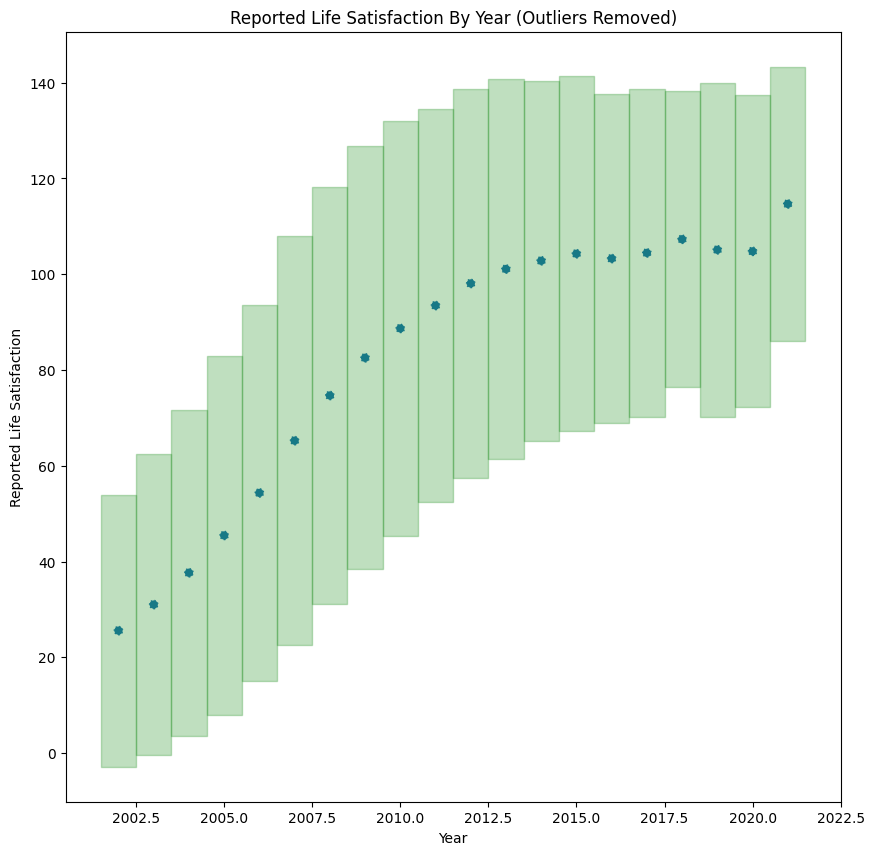

In [26]:
plot_mean(remove_out(py), "Reported Life Satisfaction By Year (Outliers Removed)", "Year", "Reported Life Satisfaction")

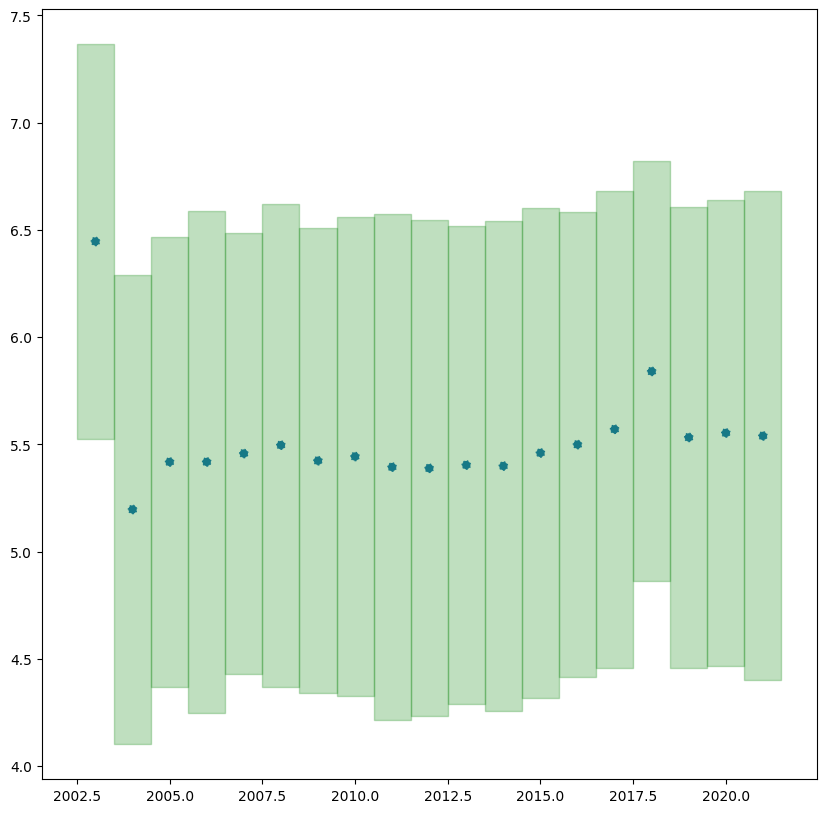

In [27]:
plot_mean(sort_map(convert_index(map_year(happiness))))

In [28]:
countries = pd.read_csv("../stats/data/csv/country_data.csv")
alpha_codes, country_codes, reverse_alpha_codes = {}, {}, {}
for i in range(0, len(countries)):
    row = countries.loc[i]
    alpha_codes[row[2].replace('"', "").replace(" ", "")] = row[1].replace('"', "").replace(" ", "")
    country_codes[row[0].replace('"', "")] = row[1].replace('"', "").replace(" ", "")
    reverse_alpha_codes[row[1].replace('"', "").replace(" ", "")] = row[2].replace('"', "").replace(" ", "")

In [29]:
def country_continent(country: str) -> str:
    alpha2 = pc.country_name_to_country_alpha2(country)
    code = pc.country_alpha2_to_continent_code(alpha2)
    name = pc.convert_continent_code_to_continent_name(code)
    return name 

def alpha_continent(alpha: str, a3=True) -> str:
    if (a3): alpha2 = alpha_codes[alpha.upper()]
    else: alpha2 = alpha
    code = pc.country_alpha2_to_continent_code(alpha2)
    name = pc.convert_continent_code_to_continent_name(code)
    return name

In [30]:
def map_region(m: map, country=False, convert=False) -> map:
    r = {}
    for k in list(m.keys()):
        if (k == "pooled"): continue
        try:
            if (country):
                a = country_codes[k]
            else: a = k

            region = alpha_continent(a, convert)

            for n in m[k]:
                n.set_loc(region)

            if (not region in r.keys()):
                r[region] = {}
                r[region][k] = m[k]
            else:
                r[region][k] = m[k]
        except: continue
    return r

def pool_nested(m: map) -> list:
    v = []
    for k in list(m.keys()):
        for j in list(m[k].keys()):
            v.extend(m[k][j])
    return v

def nested_years(m: map) -> map:
    p = {}
    v = pool_nested(m)
    for x in v:
        if (not x.year in p):
            p[x.year] = {}

        if (not x.loc in p[x.year]):
            p[x.year][x.loc] = [x.value]
        else:
            p[x.year][x.loc].append(x.value)
    return p

In [31]:
rh = nested_years(map_region(happiness, country=True, convert=False))
rp = nested_years(map_region(phones, country=False, convert=True))

In [32]:
for x in list(rh.keys()):
    nh = sort_map(rh[x])
    #merged_box(nh, f"Reported Life Satisfaction By Region ({x})", "Region", "Reported Life Satisfaction", fx=20, fy=10)

In [33]:
for x in list(rp.keys()):
    nr = sort_map(rp[x])
    #merged_box(nr, f"Cell Phones Possessed / 100 People By Region ({x})", "Region", "Cell Phones Possessed / 100 People", fx=20, fy=10)

In [34]:
def standardize(v: list) -> list:
    assert(len(v) > 0)
    z = []
    m, s = sum(v)/len(v), sd(v)
    for x in v:
        z.append((x-m)/s)
    return z

def r(x: list, y: list) -> float:
    zx, zy, r = standardize(x), standardize(y), 0
    for k in range(0, len(x)): r += zx[k] * zy[k]
    r /= len(x)-1
    return r

def regression(x: list, y: list) -> list:
    zx, zy, m, b = standardize(x), standardize(y), (sd(y)/sd(x)) * r(x,y), 0
    b = (sum(y)/len(y)) - (m * (sum(x)/len(x)))
    return [m, b]

def remove_outliers(x: list, y: list, thresh=2.5) -> list:
    reg, res = regression(x,y), residuals(x,y)[1]
    sd = data(res)["sd"]
    nx, ny = [], []
    
    for k in range(len(x)):
        rv = y[k] - (reg[0] * x[k] + reg[1])
        if (abs(rv/sd) <= thresh):
            nx.append(x[k])
            ny.append(y[k])
        
    return [nx, ny]

def residuals(x: list, y: list) -> list:
    ox, oy = [], []
    reg = regression(x, y)
    for k in range(len(x)):
        ox.append(reg[0] * x[k] + reg[1])
        oy.append(y[k] - (reg[0] * x[k] + reg[1]))
    return [ox, oy]

def regression_plot(x: list, y: list, title = "", xlabel = "", ylabel = "", fx = 30, fy = 10): 
    R = r(x, y)
    reg = regression(x, y)
    scatter(x, y, title=f"{title} (R^2 = {R**2})", xlabel=xlabel, ylabel=ylabel, m = reg[0], b = reg[1])
    return R**2

def test_regression(x: list, y: list, tf: list, its = 0, max_its = 2, xd = "x", yd = "y"):
    cxd, cyd = xd, yd
    fx, fy = x, y
    R = r(x, y)
    for t1 in tf:
        for t2 in tf:
            try:
                tx, ty = transform(x, t1.f), transform(y, t2.f)
                tR = r(tx, ty)
                if (tR > R): 
                    fx, fy = tx, ty
                    R = tR
                    cxd, cyd = t1.get_desc(xd), t2.get_desc(yd)
                    if (its >= max_its): return [fx, fy, cxd, cyd]
                    else: 
                        out = test_regression(fx, fy, tf, its+1, max_its, cxd, cyd)
                        if (r(out[0], out[1]) > R):
                            R = r(out[0], out[1])
                            [fx, fy, cxd, cyd] = out
            except: pass
                        
    return [fx, fy, cxd, cyd]
    #if (its >= max_its or (x == fx and y == fy)): return [fx, fy, cxd, cyd]
    #else: return test_regression(fx, fy, tf, its+1, max_its, cxd, cyd)

In [35]:
year_dat = {}
p_dat = [[], []]
h, p = happiness, phones
#h, p = reconstruct(filter_idx(sort_map(map_year(happiness)))), reconstruct(filter_idx(sort_map(map_year(phones))))
for x in list(h.keys()):
    if (x == "pooled"): continue
    k = reverse_alpha_codes[country_codes[x]].lower()
    if (not k in list(p.keys())): continue
    for a in h[x]:
        for b in p[k]:
            if (b.year == a.year): 
                p_dat[0].append(a.value)
                p_dat[1].append(b.value)
                if (not a.year in year_dat): year_dat[a.year] = [[a.value], [b.value]]
                else: 
                    year_dat[a.year][0].append(a.value)
                    year_dat[a.year][1].append(b.value)


In [36]:
def log(x, base:float = 10):
    return math.log(x + 0.00001)/math.log(base)

def sqrt(x):
    return math.sqrt(x)

t = {
    "a": [Value(1, 1), Value(1, 10), Value(1, 100)]
}

transform_map(t, log)

{'a': [4.342923104481638e-06, 1.0000004342942646, 2.000000043429446]}

In [37]:
class Func:
    def __init__(self, f, desc: str):
        self.f = f
        self.desc = desc
    def get_desc(self, inner: str):
        return self.desc.replace("x", inner)

0.21879053988173042

<Figure size 3000x1000 with 0 Axes>

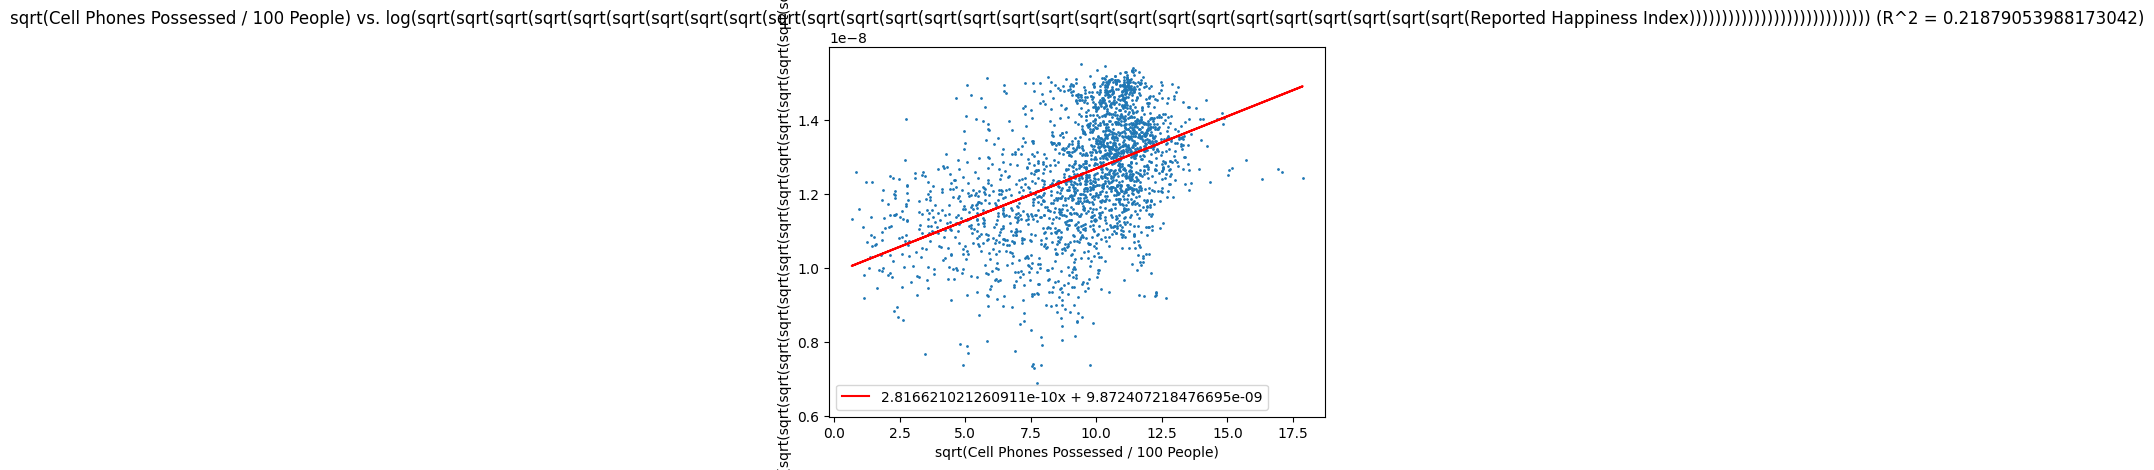

In [38]:
transformations = [
    Func(lambda x: x, "x"),
    Func(lambda x: math.sqrt(x), "sqrt(x)"),
    Func(lambda x: math.log(x), "log(x)"),
    Func(lambda x: x**2, "(x)^2"),
    Func(lambda x: 1/x, "1/(x)"),
    Func(lambda x: 1/(math.pow(x, 3)), "1/(x)^3"),
    Func(lambda x: 1/math.sqrt(x), "1/sqrt(x)"),
    Func(lambda x: -x, "-(x)")
]

[x,y,dx,dy] = test_regression(p_dat[1], p_dat[0], transformations, max_its = 300, xd = "Cell Phones Possessed / 100 People", yd = "Reported Happiness Index")
regression_plot(x,y, xlabel=dx, ylabel=dy, title = f"{dx} vs. {dy}")

0.2947287174338383

<Figure size 3000x1000 with 0 Axes>

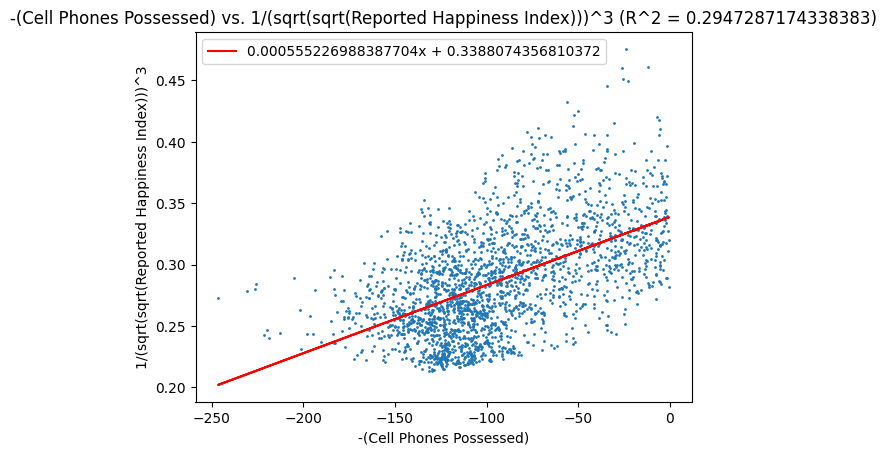

In [39]:
o_dat = remove_outliers(p_dat[1], p_dat[0], 2)
[ox, oy, odx, ody] = test_regression(o_dat[0], o_dat[1], transformations, max_its = 500, xd = "Cell Phones Possessed", yd = "Reported Happiness Index")
regression_plot(ox, oy, xlabel=odx, ylabel=ody, title = f"{odx} vs. {ody}")

[0.01310759740914487, 4.243214405216834]

<Figure size 3000x1000 with 0 Axes>

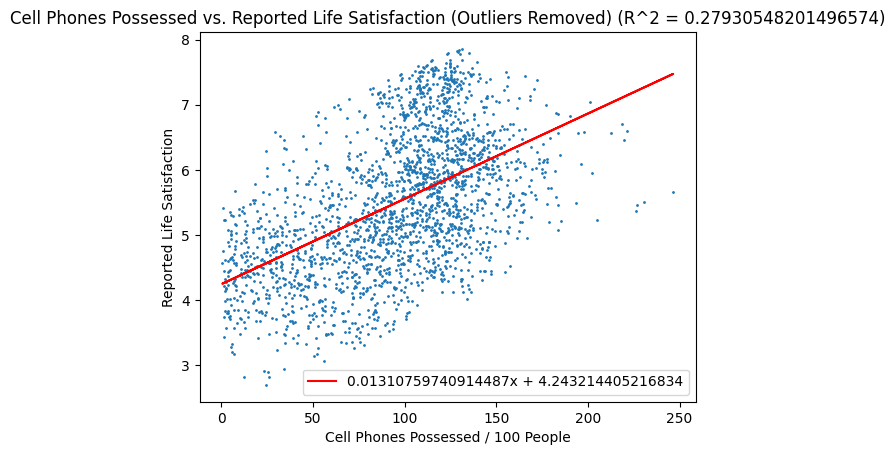

In [40]:
regression_plot(o_dat[0], o_dat[1], title = "Cell Phones Possessed vs. Reported Life Satisfaction (Outliers Removed)", ylabel = "Reported Life Satisfaction", xlabel = "Cell Phones Possessed / 100 People")
regression(o_dat[0], o_dat[1])

0.2096096447892091

<Figure size 3000x1000 with 0 Axes>

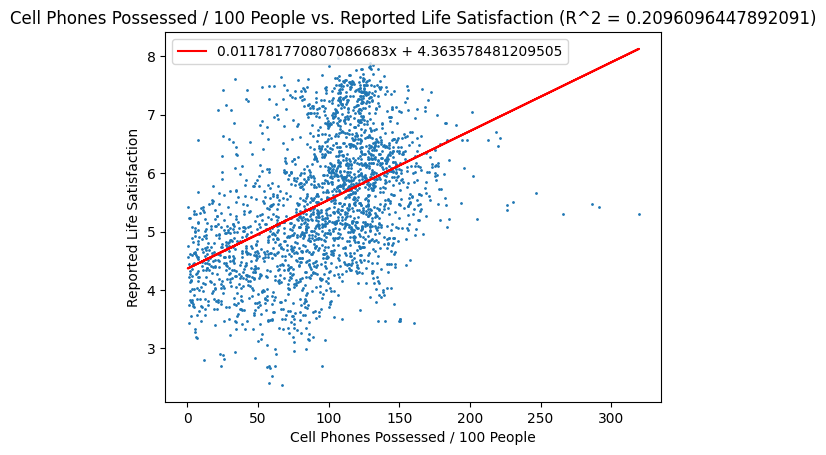

In [41]:
regression_plot(p_dat[1], p_dat[0], title = 'Cell Phones Possessed / 100 People vs. Reported Life Satisfaction', xlabel = "Cell Phones Possessed / 100 People", ylabel = "Reported Life Satisfaction")

In [42]:
th = map_region(happiness, country=True, convert=False)
tp = map_region(phones, country=False, convert=True)

In [43]:
tp

{'North America': {'abw': [<__main__.Value at 0x1ab31a67fd0>,
  'atg': [<__main__.Value at 0x1ab31a7b290>,
  'bhs': [<__main__.Value at 0x1ab34e50f90>,
  'blz': [<__main__.Value at 0x1ab34e08490>,
  'bmu': [<__main__.Value at 0x1ab34e49c50>,
  'brb': [<__main__.Value at 0x1ab34e35910>,
  'can': [<__main__.Value at 0x1ab34e315d0>,
  'cri': [<__main__.Value at 0x1ab3483d550>,
  'cub': [<__main__.Value at 0x1ab3483c890>,
  'cym': [<__main__.Value at 0x1ab34833c90>,
  'dma': [<__main__.Value at 0x1ab34817150>,
  'dom': [<__main__.Value at 0x1ab348192d0>,
  'grd': [<__main__.Value at 0x1ab34716f50>,
  'grl': [<__main__.Value at 0x1ab347176d0>,
  'gtm': [<__main__.Value at 0x1ab347f8150>,
  'hnd': [<__main__.Value at 0x1ab34734c10>,
  'hti': [<__main__.Value at 0x1ab34735610>,
  'jam': [<__main__.Value at 0x1ab34fca150>,
  'kna': [<__main__.Value at 0x1ab347fc090>,
  'lca': [<__main__.Value at 0x1ab346f0250>,
  'mex': [<__main__.Value at 0x1ab346d15d0>,
  'nic': [<__main__.Value at 0x1ab3474

In [44]:
j_dat = {}

In [45]:
for k in list(th.keys()):
    j_dat[k] = [[],[]]
    for x in list(th[k].keys()):
        code = reverse_alpha_codes[country_codes[x]].lower()
        if (not code in tp[k].keys() or x == "pooled"): continue
        for a in th[k][x]:
            for b in tp[k][code]:
                if (b.year == a.year):
                    j_dat[k][0].append(a.value)
                    j_dat[k][1].append(b.value)

In [46]:
j_dat

{'Asia': [[3.72359,
   4.401778,
   4.758381,
   3.8317192,
   3.7829375,
   3.5721004,
   3.1308956,
   3.9828546,
   4.2201686,
   2.6617181,
   2.6943033,
   2.3750918,
   2.5229,
   2.4038,
   4.289311,
   4.8815155,
   4.6519723,
   4.177582,
   4.367811,
   4.2604914,
   4.3197117,
   4.277191,
   4.453083,
   4.3483195,
   4.325472,
   4.2877364,
   5.0624485,
   5.4880867,
   5.2826,
   5.3986,
   5.3417,
   4.727871,
   4.5681596,
   4.817189,
   4.573725,
   4.218611,
   4.6804695,
   4.910772,
   5.4811783,
   5.25153,
   5.146775,
   5.303895,
   5.1522794,
   5.1679955,
   5.1733894,
   5.1708,
   5.1734,
   5.7005234,
   5.936869,
   4.823976,
   5.027187,
   6.689711,
   6.165134,
   6.0073752,
   6.1696734,
   6.2273207,
   7.0980124,
   6.173176,
   6.6469,
   6.6469,
   6.1732,
   4.318909,
   4.607322,
   5.0522785,
   5.0828514,
   4.8584814,
   4.985649,
   4.724444,
   4.660161,
   4.635565,
   4.633474,
   4.556141,
   4.309771,
   4.499217,
   5.114217,
   5.279

<Figure size 3000x1000 with 0 Axes>

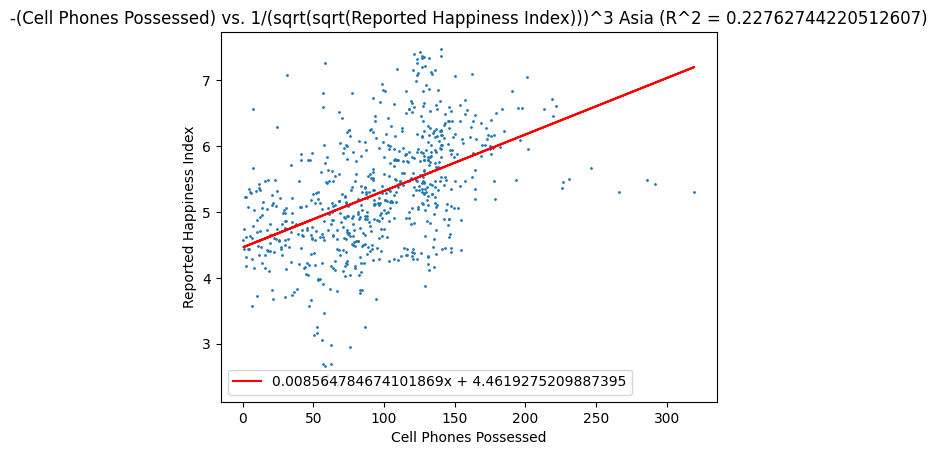

<Figure size 3000x1000 with 0 Axes>

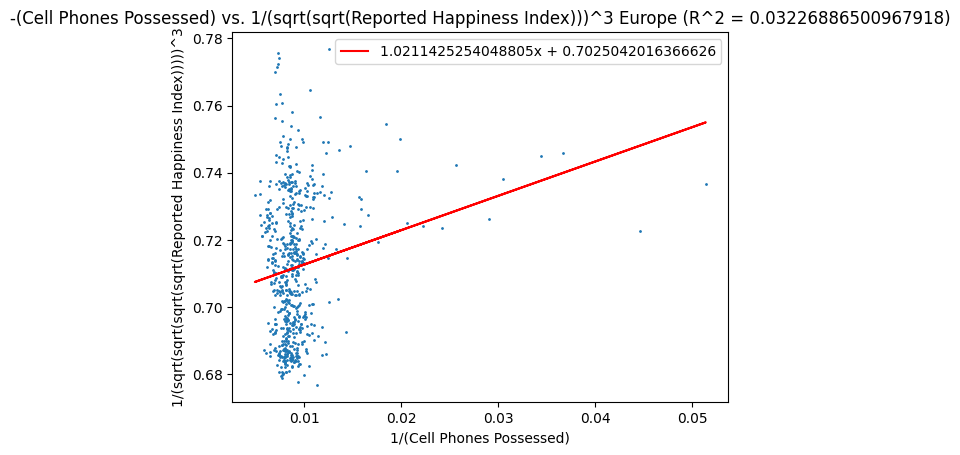

<Figure size 3000x1000 with 0 Axes>

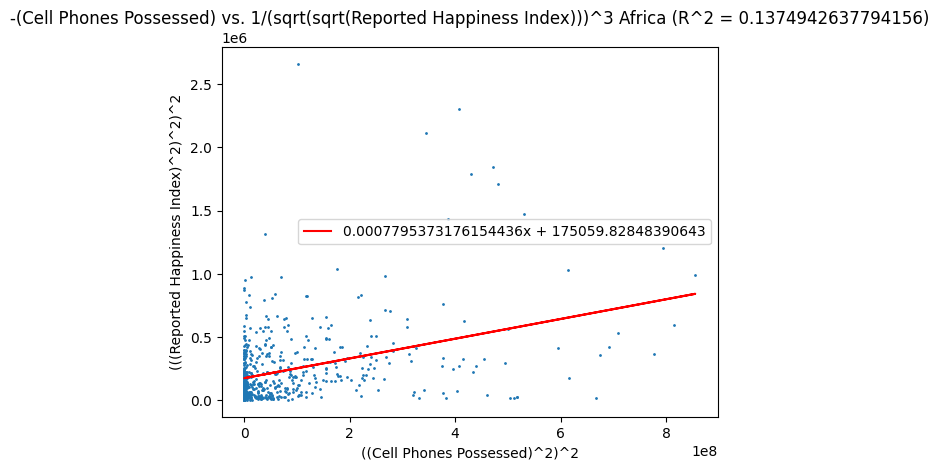

<Figure size 3000x1000 with 0 Axes>

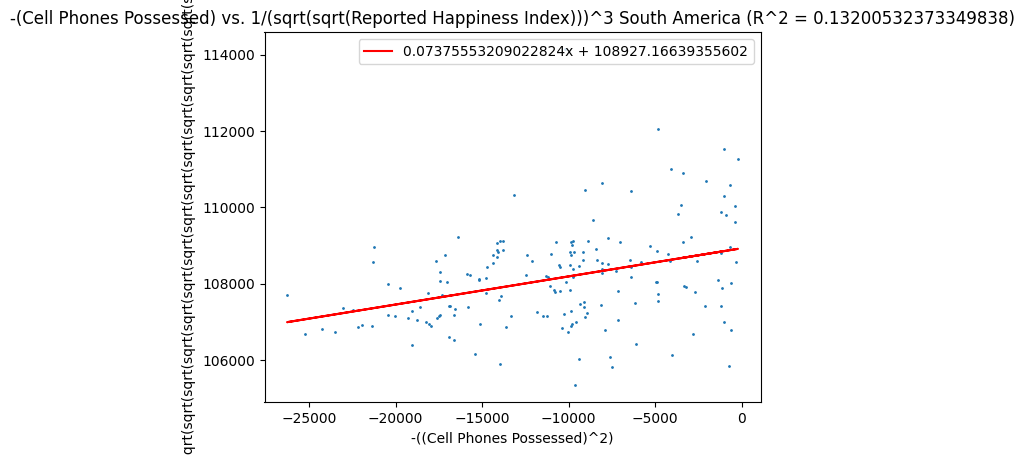

<Figure size 3000x1000 with 0 Axes>

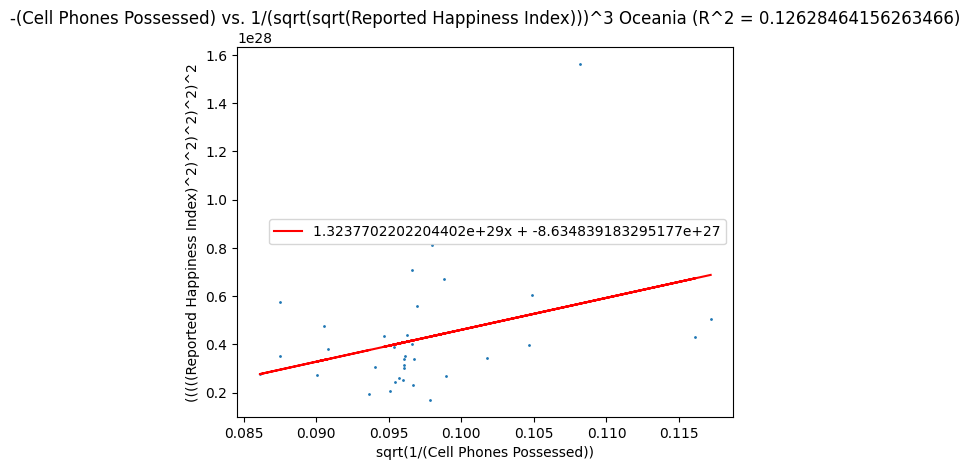

<Figure size 3000x1000 with 0 Axes>

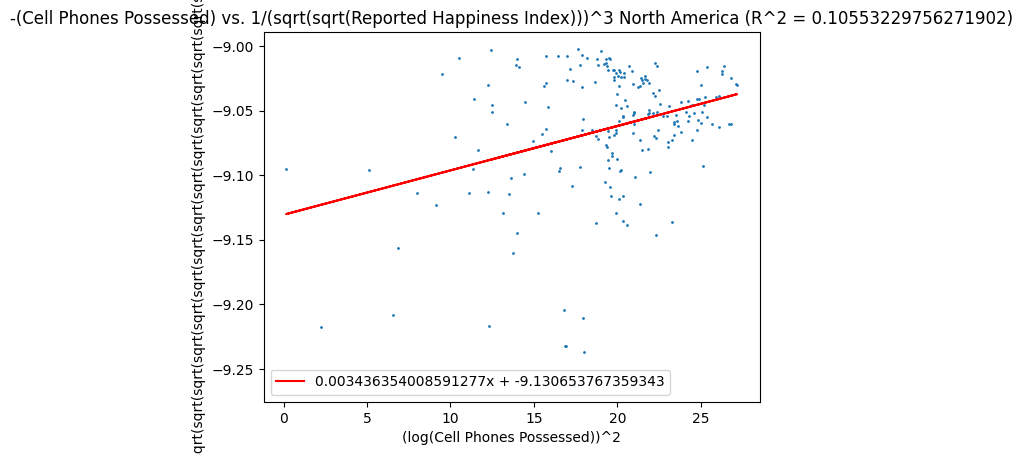

In [47]:
for k in list(j_dat.keys()):
    [kx, ky, kdx, kdy] = test_regression(j_dat[k][1], j_dat[k][0], transformations, max_its = 30, xd = "Cell Phones Possessed", yd = "Reported Happiness Index")
    regression_plot(kx, ky, xlabel=kdx, ylabel=kdy, title = f"{odx} vs. {ody} {k}")

In [56]:
def sd_e(values: list) -> float:
    s = 0
    for x in values:
        s += x*x
    return math.sqrt(s)/(len(values)-2)

def t_n(x: list, y: list) -> float:
    n = len(x)
    res = residuals(x, y)
    sx, se = sd(x), sd_e(res[1])
    print(se)
    
    s_b = se/(math.sqrt(n-1) * sx)
    print(s_b)
    m = regression(x,y)[0]
    return m/s_b

def p_t(t: float, df: int, ts=True) -> float:
    p = scipy.stats.t.sf(abs(t), df=df)
    if (ts): return 2*p
    return p

In [57]:
t_n(p_dat[1], p_dat[0])

0.020460635675050153
9.835943938183575e-06


1197.8281780713817

In [55]:
len(p_dat[0])

2328